In [1]:
import sys
!{sys.executable} -m pip install colossus
!{sys.executable} -m pip install emcee
!{sys.executable} -m pip install corner

In [2]:
import numpy as np
import scipy
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from scipy.optimize import curve_fit

import emcee
import corner

mpl.rcParams['agg.path.chunksize'] = 10000  # This is required to correctly plot the mass function evaluated on the data array



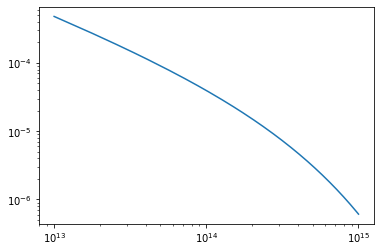

In [3]:

## cosmology.setCosmology('WMAP9') This is a default cosmology

params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.048254, 'sigma8': 0.81, 'ns': 0.96} # This sets a customized cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Array of masses
m_arr = np.linspace(1E13,1E15,128)

##for mass in m_arr:
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM') # q_out modifies the output function
##    mfunc_fof = mass_function.massFunction(mass, 0.0, mdef = 'fof', model = 'watson13', q_out = dndlnM))
plt.loglog(m_arr,  mfunc_so)


plt.show()   

In [4]:
a = np.load('converted_catalog_z0.000_mock0001.npz') # Import the catalog and read through it
print(a.files)
print(a['mass'].shape) # a['masss] is an array with 2772758 components
print(a['mass'].shape)
print(np.max(a['mass']))
print(len(a['mass']))
print(np.max(a['pos']))

print(np.log10(np.e))
BoxVolume = np.amax(a['pos'])**3.

print(BoxVolume)

['mass', 'pos']
(2772758,)
(2772758,)
5705458771838476.0
2772758
3869.9985
0.4342944819032518
57960537183.56983


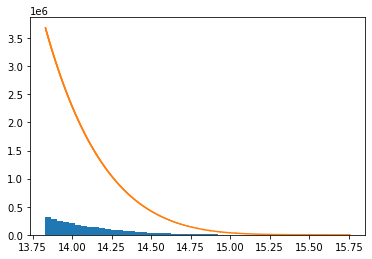

In [5]:
xmin = np.min(a['mass'])
xmax = np.max(a['mass'])
plt.hist(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ) )#Histogram of log-mass catalog, density=True gives a normalized histogram


m_arr = a['mass']
m_arr.sort() # order by increasing value
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

plt.plot(np.log10(m_arr), BoxVolume*mfunc_so) 
plt.show()

[50.00001946  0.1         0.8       ]


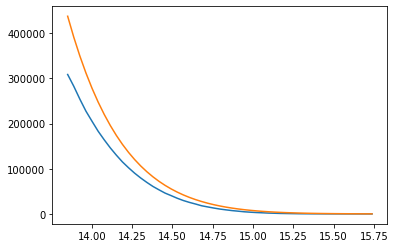

In [7]:
bin_heights, bin_borders = np.histogram(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ))
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

# Let us perform a preliminary fit
def func(x, a1, a2, a3):
    params = {'flat': True, 'H0': a1, 'Om0': a2, 'Ob0': 0.049,'sigma8': a3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata = 10**(bin_centers)
ydata = bin_heights

popt, pcov = curve_fit(func, xdata, ydata, p0=[67., 0.3, 0.8], bounds=([50., 0.1, 0.1],[75, 0.5, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata), ydata)
plt.plot(np.log10(xdata), func(xdata, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

In [21]:
# Let us write the Likelihood function

def massfunction(theta, mass):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = np.array(BoxVolume*mass_function.massFunction(mass, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so

def log_prior(theta):
    Om0, sigma8 = theta
    if 0.0 < Om0 < 1.0 and 0.0 < sigma8 < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, mass, ydata):
    #err = DM_err What do I use as error array?
    mfunc_so = massfunction(theta, mass)
    logl = np.sum(mfunc_so*np.log(ydata)- ydata)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl

def log_posterior(theta, mass, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(theta, mass, ydata)
    logpos = logl+lp
    return logpos


pos = [0.3,0.8] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(pos, 2000, progress=True)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 54.22it/s]


State([[0.49778531 0.04875784]
 [0.62819755 0.23657024]
 [0.71179978 0.26784106]
 [0.76924643 0.0843583 ]
 [0.76848041 0.92610147]
 [0.46374617 0.34394138]
 [0.28217857 0.68786972]
 [0.83275631 0.1177274 ]
 [0.4238461  0.55397514]
 [0.43302472 0.83116028]
 [0.33697178 0.5869242 ]
 [0.77094423 0.11734781]
 [0.55967917 0.39024968]
 [0.88002958 0.8114392 ]
 [0.63462816 0.84165793]
 [0.58114081 0.06386567]], log_prob=[42483374.74401977 42483374.74401977 42483374.74401977 42483374.74401977
 42483374.74401977 42483374.74401977 42483374.74401977 42483374.74401977
 42483374.74401977 42483374.74401977 42483374.74401977 42483374.74401977
 42483374.74401977 42483374.74401977 42483374.74401977 42483374.74401977], blobs=None, random_state=('MT19937', array([  90790669,  353858660, 3386791233,  281842668, 3009105051,
       3336704784, 3544661700, 1647043851,  564110703, 3554430257,
        729836397, 3937156201, 1015870605, 1502844224, 1505683219,
        279809725, 2629685566, 3474421387, 27779880

(2000, 16, 2)


Text(0.5, 0, 'step number')

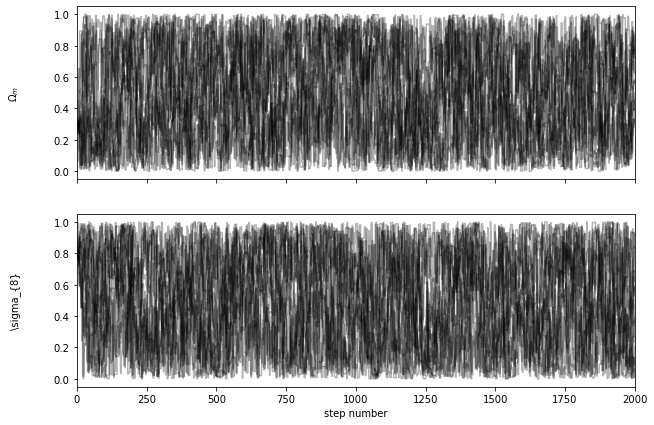

In [22]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["$\Omega_{m}$", "\sigma_{8}"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

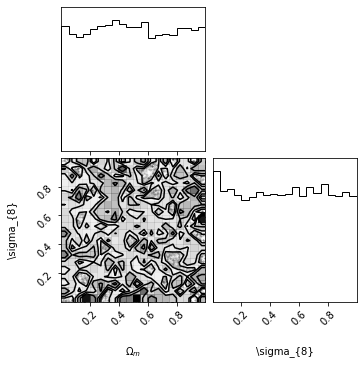

In [23]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels)